# HSCT survival: linear regression model

## Notebook set-up

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-no_multicollinearity_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
poly_training_features_data_file=f'{config.DATA_PATH}/processed/03.1-polynomial_training_features_df.parquet'
poly_testing_features_data_file=f'{config.DATA_PATH}/processed/03.1-polynomial_testing_features_df.parquet'

# Model files
model_file=f'{config.MODELS_PATH}/03.1-linear_regression.pkl'
poly_model_file=f'{config.MODELS_PATH}/03.1-linear_regression_polynomial_features.pkl'
poly_features_transformer_file=f'{config.MODELS_PATH}/03.1-poly_features_transformer.pkl'

# Scoring results
model_scores_file=f'{config.DATA_PATH}/results/data/03.1-model_scores.pkl'

## 1. Load data

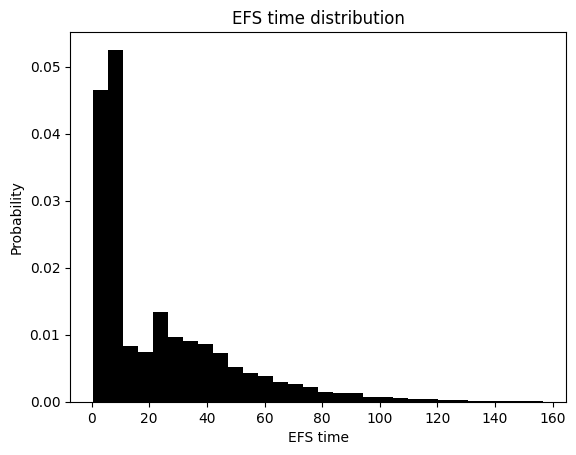

Training features: (28800, 118)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

## 2. Data preparation

### 2.1. Train-test split

In [3]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

### 2.2. Save and remove training & testing race group

In [4]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

### 2.3. Make features and labels

In [5]:
training_labels_df=training_df[['efs', 'efs_time']].copy()
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
training_labels_df['sqrt_efs_time']=training_labels_df['efs_time']**0.5
training_labels_df['log_efs_time']=np.log(training_labels_df['efs_time'])
training_labels_df['reciprocal_efs_time']=1/training_labels_df['efs_time']

testing_labels_df=testing_df[['efs', 'efs_time']].copy()
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)
testing_labels_df['sqrt_efs_time']=testing_labels_df['efs_time']**0.5
testing_labels_df['log_efs_time']=np.log(testing_labels_df['efs_time'])
testing_labels_df['reciprocal_efs_time']=1/testing_labels_df['efs_time']

### 2.4. Standard scale features

In [6]:
scaler=StandardScaler()
scaler.fit(training_features_df)

training_index=training_features_df.index
testing_index=testing_features_df.index

training_features=scaler.transform(training_features_df)
testing_features=scaler.transform(testing_features_df)

training_features_df=pd.DataFrame(training_features, columns=training_features_df.columns)
testing_features_df=pd.DataFrame(testing_features, columns=testing_features_df.columns)

training_features_df.set_index(training_index, inplace=True)
testing_features_df.set_index(testing_index, inplace=True)

## 3. Models

In [7]:
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

### 3.1. Linear regression model: label transformation testing

Label type: efs_time


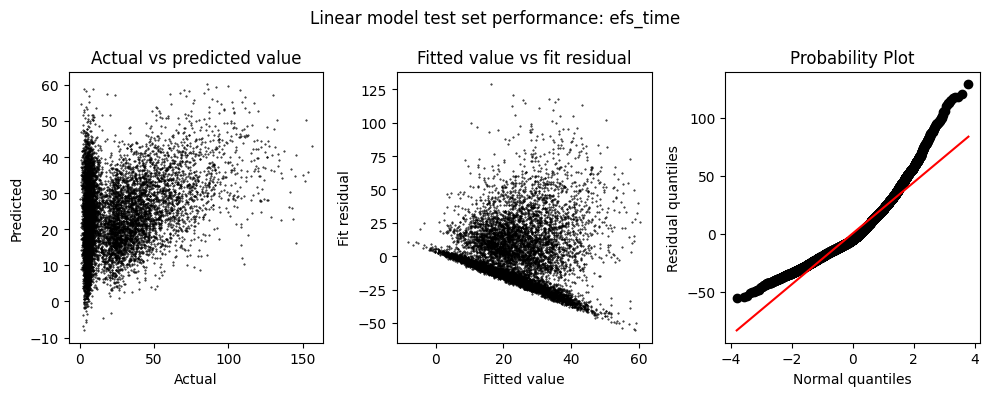

Label type: log_efs_time


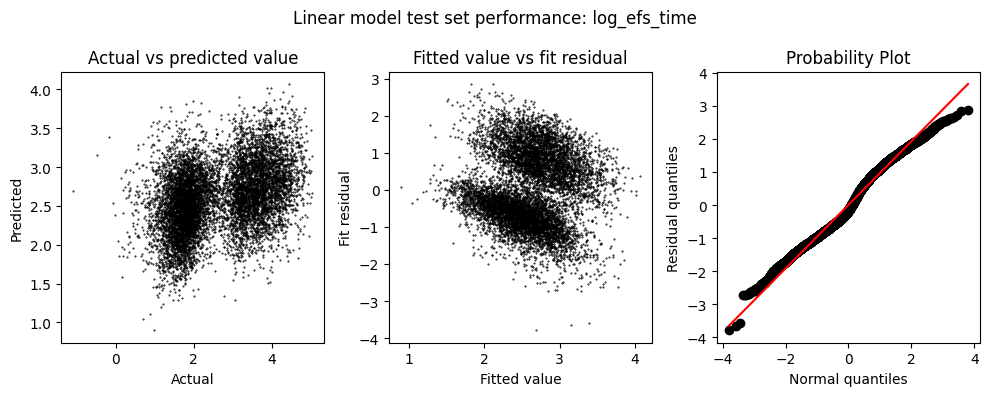

Label type: sqrt_efs_time


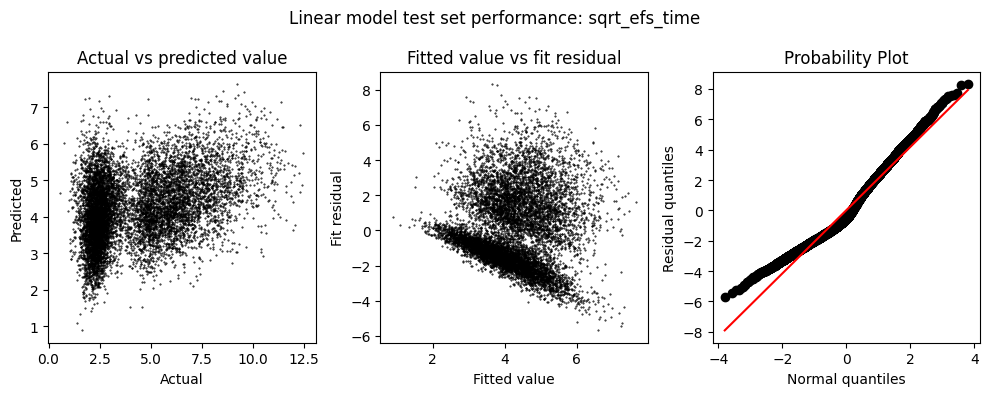

Label type: reciprocal_efs_time


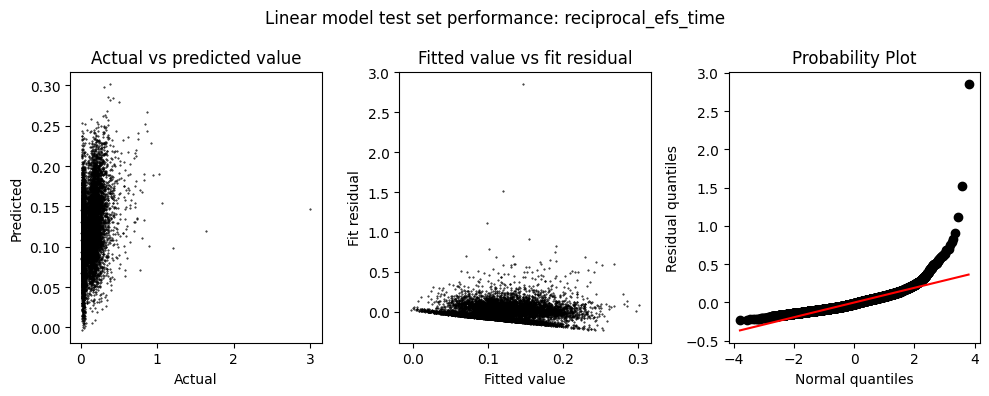

In [8]:
label_types=['efs_time', 'log_efs_time', 'sqrt_efs_time', 'reciprocal_efs_time']

for label_type in label_types:

    print(f'Label type: {label_type}')

    model=LinearRegression()
    model.fit(training_features_df, training_labels_df[label_type])

    # Make predictions for the test set
    predicted_efs_time=model.predict(testing_features_df)

    # Score the predictions
    scoring_results=helper_funcs.score_predictions(
        model_description=f'Linear, {label_type} label',
        predictions=predicted_efs_time,
        labels_df=testing_labels_df,
        race_group=testing_race_group,
        results=scoring_results,
        label_type=label_type
    )

    plot=plot_funcs.prediction_eval_plot(
        f'Linear model test set performance: {label_type}',
        predicted_efs_time,
        testing_labels_df[label_type]
    )

    # Save the plot
    plot.savefig(f'{config.DATA_PATH}/results/plots/03.1-performance_linear_model_{label_type}.jpg', dpi=300)
    plot.show()

### 3.2. Linear regression: polynomial features

#### 3.2.1. Make/load polynomial features

In [ ]:
# Fit polynomial feature transformer on training data
poly=PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly.fit(training_features_df)

# Create polynomial interaction features for training and testing data
poly_training_data=poly.transform(training_features_df)
poly_testing_data=poly.transform(testing_features_df)

# Convert new features into dataframes
poly_interaction_training_features_df=pd.DataFrame(poly_training_data)
poly_interaction_testing_features_df=pd.DataFrame(poly_testing_data)

# Make the column names string
poly_interaction_training_features_df.columns=poly_interaction_training_features_df.columns.astype(str)
poly_interaction_testing_features_df.columns=poly_interaction_testing_features_df.columns.astype(str)
print(f'Training data interaction features: {poly_interaction_training_features_df.shape}')

# Add the interaction features back to the original features
poly_training_features_df=pd.concat([
    poly_interaction_training_features_df.reset_index(drop=True),
    training_features_df.reset_index(drop=True)
],axis=1)

poly_training_features_df.index=training_features_df.index

poly_testing_features_df=pd.concat([
    poly_interaction_testing_features_df.reset_index(drop=True),
    testing_features_df.reset_index(drop=True)
],axis=1)

poly_testing_features_df.index=testing_features_df.index

print(f'Polynomial training data: {poly_training_features_df.shape}')

Training data interaction features: (19296, 6670)
Polynomial training data: (19296, 6785)


In [10]:
poly_interaction_training_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
0,-0.914704,0.208502,0.215701,0.245271,0.196735,0.613531,0.203664,0.094715,0.192290,-0.446851,...,-0.740853,0.518290,-0.206220,-0.420820,-0.505485,0.201125,0.410423,-0.140704,-0.287126,0.114243
1,0.563738,-0.606802,-1.864081,-0.974242,-0.927500,-1.768693,-1.893305,0.571033,-1.642515,-1.937764,...,-0.740853,-1.465628,-0.206220,-0.420820,1.429417,0.201125,0.410423,0.397886,0.811939,0.114243
2,0.563738,0.752038,0.735646,0.767920,0.758853,0.613531,0.727906,0.571033,0.650992,0.547090,...,-0.740853,0.518290,-0.206220,-0.420820,-0.505485,0.201125,0.410423,-0.140704,-0.287126,0.114243
3,0.563738,0.752038,0.735646,0.767920,0.758853,0.613531,0.727906,0.571033,0.192290,0.547090,...,-0.740853,0.518290,-0.206220,-0.420820,-0.505485,0.201125,0.410423,-0.140704,-0.287126,0.114243
4,0.563738,0.072618,-0.997505,-0.103161,0.196735,0.613531,-0.145831,0.571033,0.650992,0.547090,...,-1.349795,-0.682302,0.271478,0.553987,0.699586,-0.278355,-0.568021,-0.140704,-0.287126,0.114243


#### 3.2.2. Test set performance

Label type: efs_time


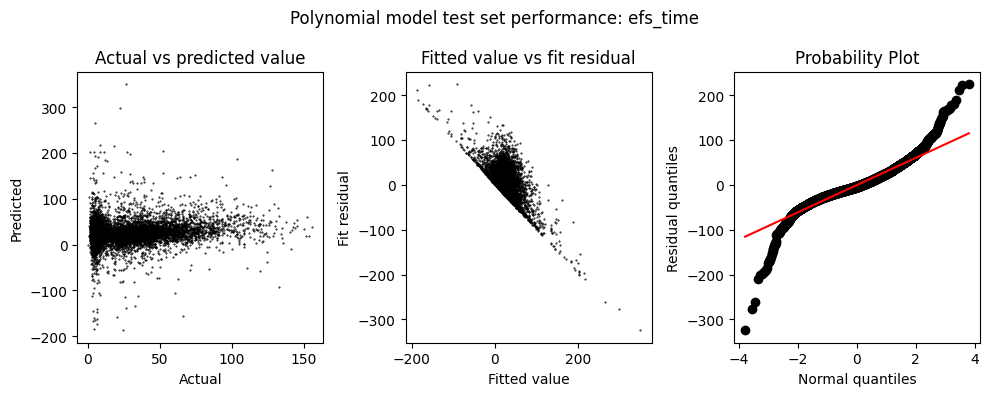

Label type: log_efs_time


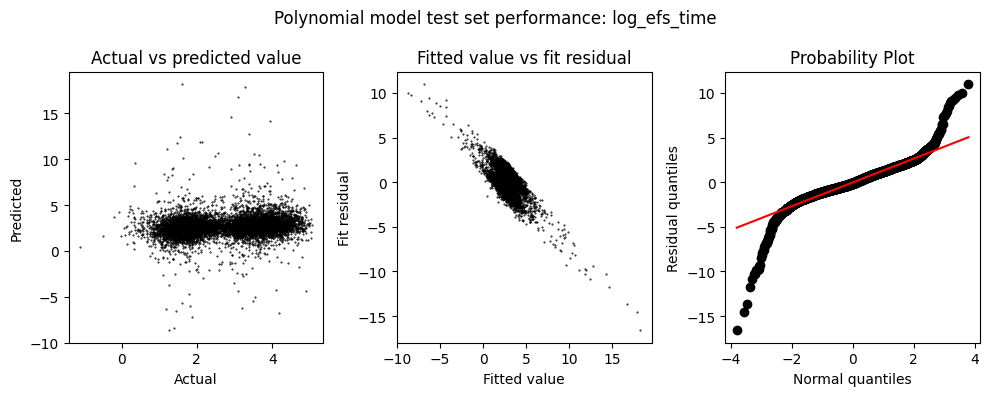

Label type: sqrt_efs_time


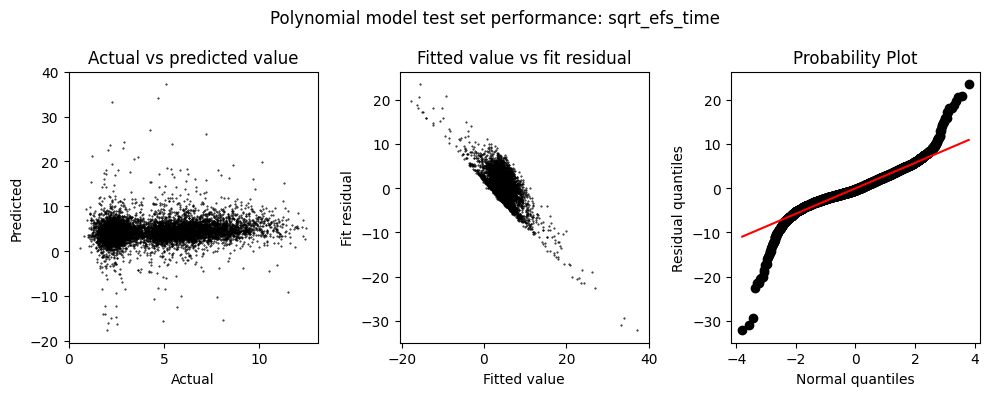

Label type: reciprocal_efs_time


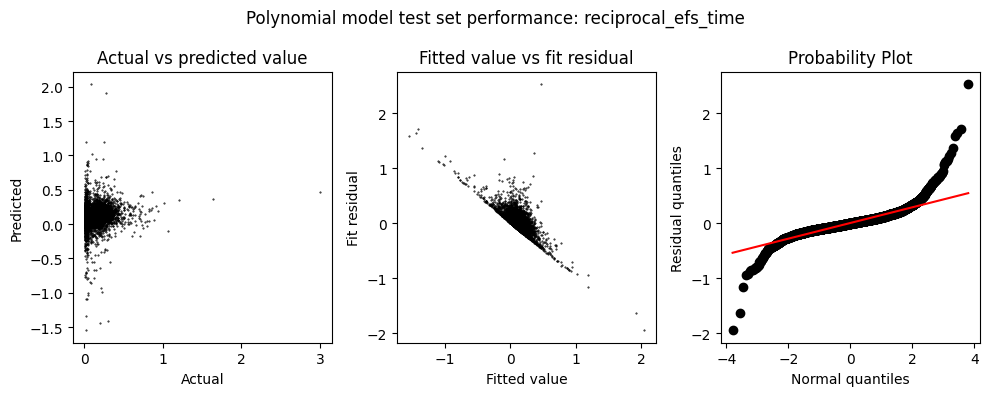

In [11]:
label_types=['efs_time', 'log_efs_time', 'sqrt_efs_time', 'reciprocal_efs_time']

for label_type in label_types:

    print(f'Label type: {label_type}')

    poly_model=LinearRegression()
    poly_model.fit(poly_training_features_df, training_labels_df[label_type])

    # Make predictions on the training set
    poly_predicted_efs_time=poly_model.predict(poly_testing_features_df)

    scoring_results=helper_funcs.score_predictions(
        model_description=f'Polynomial, {label_type} label',
        predictions=poly_predicted_efs_time,
        labels_df=testing_labels_df,
        race_group=testing_race_group,
        results=scoring_results,
        label_type=label_type
    )

    plot_funcs.prediction_eval_plot(
        f'Polynomial model test set performance: {label_type}',
        poly_predicted_efs_time,
        testing_labels_df[label_type]
    )

    # Save the plot
    plt.savefig(f'{config.DATA_PATH}/results/plots/03.1-performance_polynomial_model_{label_type}.jpg', dpi=300)
    plt.show()

## 4. Model comparison: test set performance

In [12]:
scoring_results_df=pd.DataFrame.from_dict(scoring_results)
scoring_results_df.to_csv(model_scores_file, index=False)
scoring_results_df.head(len(scoring_results_df))

,Model,RMSE,C-index,Stratified C-index
0,"Linear, efs_time label",22.759548,0.599130,0.490373
1,"Linear, log_efs_time label",0.972367,0.648450,0.487377
2,"Linear, sqrt_efs_time label",2.122439,0.626060,0.488620
3,"Linear, reciprocal_efs_time label",0.105140,0.588801,0.480360
4,"Polynomial, efs_time label",31.491652,0.562092,0.483058
5,"Polynomial, log_efs_time label",1.387380,0.594548,0.481448
6,"Polynomial, sqrt_efs_time label",2.983921,0.580238,0.482050
7,"Polynomial, reciprocal_efs_time label",0.154460,0.569146,0.490277
